# Восстановление золота из руды

## Задание

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.<br>
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки.<br>
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Описание данных

**Общая информация**<br>
Данные находятся в трёх файлах:
- `gold_recovery_train_new.csv` — обучающая выборка;
- `gold_recovery_test_new.csv` — тестовая выборка;
- `gold_recovery_full_new.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.<br>
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.<br>
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.<br>
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

**Технологический процесс**
- <i>Rougher feed</i> — исходное сырье
- <i>Rougher additions</i> (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - <i>Xanthate</i> — ксантогенат (промотер, или активатор флотации);
    - <i>Sulphate</i> — сульфат (на данном производстве сульфид натрия);
    - <i>Depressant</i> — депрессант (силикат натрия).
- <i>Rougher process (англ. «грубый процесс»)</i> — флотация
- <i>Rougher tails</i> — отвальные хвосты
- <i>Float banks</i> — флотационная установка
- <i>Cleaner process</i> — очистка
- <i>Rougher Au</i> — черновой концентрат золота
- <i>Final Au</i> — финальный концентрат золота

**Параметры этапов**
- <i>air amount</i> — объём воздуха
- <i>fluid levels</i> — уровень жидкости
- <i>feed size</i> — размер гранул сырья
- <i>feed rate</i> — скорость подачи


**Наименование признаков**<br>
Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`. Пример: `rougher.input.feed_ag`<br>
Возможные значения для блока `[этап]`:
- <i>rougher</i> — флотация
- <i>primary_cleaner</i> — первичная очистка
- <i>secondary_cleaner</i> — вторичная очистка
- <i>final</i> — финальные характеристики
Возможные значения для блока `[тип_параметра]`:
- <i>input</i> — параметры сырья
- <i>output</i> — параметры продукта
- <i>state</i> — параметры, характеризующие текущее состояние этапа
- <i>calculation</i> — расчётные характеристики


# Ход работы

## 0. Импорт библиотек и настройки

In [1]:
# Импорт необходимых для исследования библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# Для удобства
from tqdm import tqdm

# Работа с моделями
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

In [2]:
# Устанавливаем настройки отображения
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 1. Подготовка данных

### 1.1. Загрузка данных и первый взгляд на датасет.

#### 1.1.1. Загрузка.

In [3]:
# Загрузим таблицы в разные датафреймы
rec_sets = ['train', 'test', 'full']
df = {}

for rec_set in rec_sets:
    try:
        df[rec_set] = pd.read_csv('/datasets/gold_recovery_' + str(rec_set) + '_new.csv')
    except:
        df[rec_set] = pd.read_csv('datasets/gold_recovery_' + str(rec_set) + '_new.csv')

#### 1.1.2. Первый взгляд на данные.
Эти данные модуль `ydata-profiling` не очень охотно и долго переваривает, обойдусь обычными методами.

In [4]:
# Общая информация о данных
for i in rec_sets:
    print('--'*50)
    print(f'Таблица {i}: {df[i].shape[0]} строк, {df[i].shape[1]} столбцов')
    print('--'*20)
    display(df[i].info())

----------------------------------------------------------------------------------------------------
Таблица train: 14149 строк, 87 столбцов
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                1414

None

----------------------------------------------------------------------------------------------------
Таблица test: 5290 строк, 53 столбцов
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 no

None

----------------------------------------------------------------------------------------------------
Таблица full: 19439 строк, 87 столбцов
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438

None

Сразу видим пропуски, тип данных в столбце date интуитивно некорректный. Посмотрим, что в таблицах:

In [5]:
for i in rec_sets:
    print('--'*50)
    print(f'Таблица {i}')
    display(df[i][:10])

----------------------------------------------------------------------------------------------------
Таблица train


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

----------------------------------------------------------------------------------------------------
Таблица test


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

----------------------------------------------------------------------------------------------------
Таблица full


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

#### 1.1.3. Описательная статистика.

In [6]:
for i in rec_sets:
    print('--'*50)
    print(f'Таблица {i}')
    display(df[i].describe())

----------------------------------------------------------------------------------------------------
Таблица train


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

----------------------------------------------------------------------------------------------------
Таблица test


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

----------------------------------------------------------------------------------------------------
Таблица full


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

Видны аномально малые значения, также присутствуют большие отклонения.

#### 1.1.4. Пропуски.

In [7]:
for i in rec_sets:
    print(f'Доля объектов с пропусками в таблице {i}:\t{len(df[i][df[i].isna().any(axis=1)])/len(df[i]):%}')

Доля объектов с пропусками в таблице train:	22.135840%
Доля объектов с пропусками в таблице test:	1.153119%
Доля объектов с пропусками в таблице full:	17.207675%


In [8]:
for i in rec_sets:
    print('--'*50)
    print(f'таблица {i}')
    print('--'*10)
    display(df[i].isna().sum())

----------------------------------------------------------------------------------------------------
таблица train
--------------------


date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     0
final.output.tail_pb                                   100
final.output.tail_sol                                    5
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           20
primary_cleaner.input.depressant                        32
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                   86
primary_cleaner.output.concentrate_sol                 2

----------------------------------------------------------------------------------------------------
таблица test
--------------------


date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

----------------------------------------------------------------------------------------------------
таблица full
--------------------


date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     1
final.output.tail_pb                                   101
final.output.tail_sol                                    6
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           24
primary_cleaner.input.depressant                        37
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         104
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.output.concentrate_sol                 3

Количество пропусков огромное, просто удалять не пойдёт.

#### 1.1.5. Взаимная корреляция признаков.

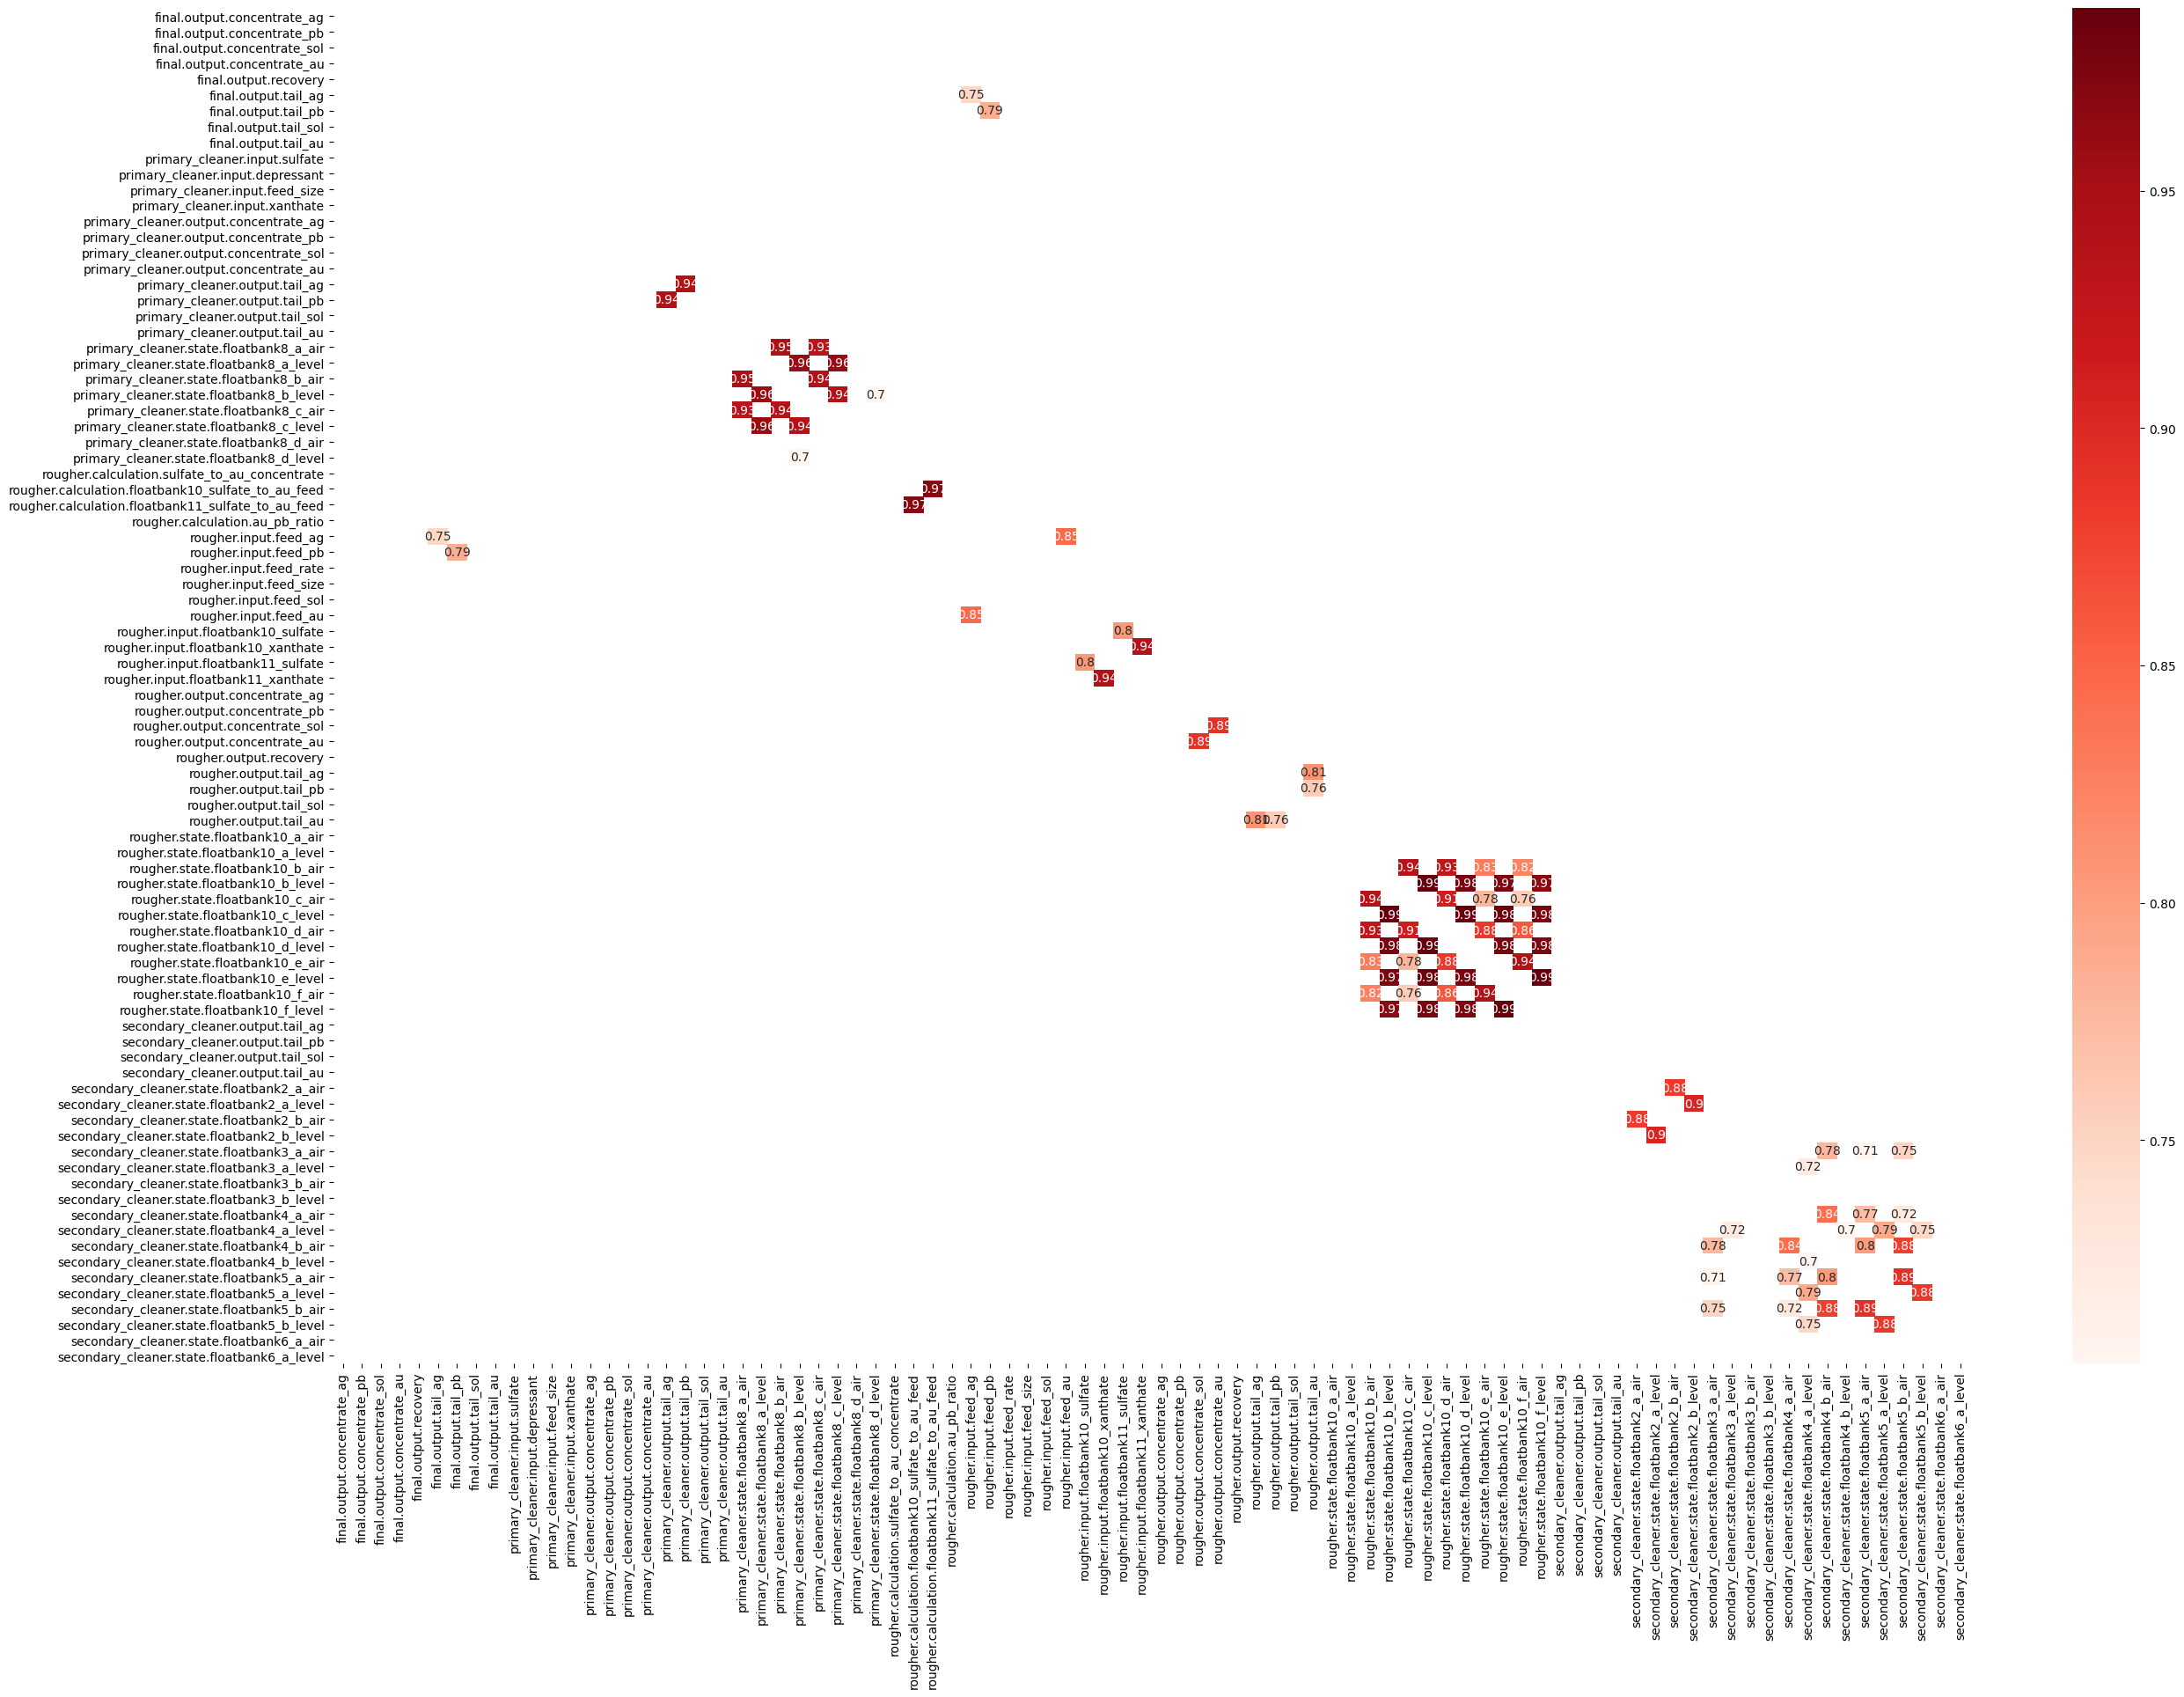

In [9]:
# Создаём датафрейм для визуализации
df_corr = df['train'].corr().abs()

# Условие отображения - взаимная корреляция Пирсона больше 0,7 и не равна 1
df_corr = df_corr[((df_corr >= .7)) & (df_corr !=1.000)]

# Выводим
plt.figure(figsize=(30,20))
sns.heatmap(df_corr, annot=True, cmap="Reds")
plt.show()

In [10]:
# Вывод списком
corr_cols = df_corr.unstack().sort_values(ascending=False).drop_duplicates()
display(corr_cols[corr_cols > 0.7].shape)
display(corr_cols[corr_cols > 0.7])

(53,)

rougher.state.floatbank10_f_level                   rougher.state.floatbank10_e_level                     0.988426
rougher.state.floatbank10_b_level                   rougher.state.floatbank10_c_level                     0.988065
rougher.state.floatbank10_d_level                   rougher.state.floatbank10_c_level                     0.987670
rougher.state.floatbank10_e_level                   rougher.state.floatbank10_c_level                     0.984585
rougher.state.floatbank10_d_level                   rougher.state.floatbank10_b_level                     0.978083
rougher.state.floatbank10_f_level                   rougher.state.floatbank10_c_level                     0.977216
rougher.state.floatbank10_d_level                   rougher.state.floatbank10_e_level                     0.977010
rougher.state.floatbank10_f_level                   rougher.state.floatbank10_d_level                     0.975010
rougher.state.floatbank10_e_level                   rougher.state.floatbank10_b_

53 взаимнокоррелирующих признака, но торопиться их резать не ст*о*ит. Можно использовать модели, не зависящие от этого.

#### 1.1.6. Вывод.

1. Больше 10% пропусков. Нужно внимательно оценить, чем заполнить, а что можно удалить.
2. Есть выбросы.
3. У многих признаков сильная взаимная корреляция.

### 1.2. Проверка правильности расчёта эффективности обогащения.

Эффективность обогащения рассчитывается по формуле:

$$Recovery = \frac{C\times(F-T)}{F\times(C-T)}\times 100\%$$

где:
- C — доля золота в концентрате после флотации/очистки;- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

К счастью, в нужных столбцах пропусков нет, и все расчёты я могу сделать сразу.

In [11]:
def rec_calc(f:float, c:float, t:float, r:float) -> float:
    '''
    Функция расчёта эффективности обогащения и MAE. На вход принимает параметры:
    f = rougher.input.feed_au
    c = rougher.output.concentrate_au
    t = rougher.output.tail_au
    r = rougher.output.recovery
    
    Отдаёт расчётное значение обогащения recovery.
    '''
    recovery = c*(f - t) / (f*(c - t)) * 100
 
    return recovery

In [12]:
# Применим функцию к датафрейму
df['train']['rougher.output.recovery.check'] = rec_calc(df['train']['rougher.input.feed_au'],
                                                        df['train']['rougher.output.concentrate_au'],
                                                        df['train']['rougher.output.tail_au'],
                                                        df['train']['rougher.output.recovery'])

In [13]:
# Посчитаем ошибку вычислений
print('MAE разницы вычислений:', abs((df['train']['rougher.output.recovery'] - df['train']['rougher.output.recovery.check'])).sum() / len(df['train']['rougher.output.recovery']))

# Сравним с данными
display(df['train'][df['train']['rougher.output.recovery'] - df['train']['rougher.output.recovery.check'] !=0]['rougher.output.recovery.check'].count())
display(df['train'][['rougher.output.recovery', 'rougher.output.recovery.check']][:15])

MAE разницы вычислений: 9.73512347450521e-15


7437

,rougher.output.recovery,rougher.output.recovery.check
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
5,88.156912,88.156912
6,88.168065,88.168065
7,87.668336,87.668336
8,87.035862,87.035862
9,87.650868,87.650868


In [14]:
# Удалим ненужный столбец после проверки
df['train'] = df['train'].drop('rougher.output.recovery.check', axis=1)

Мизерная ошибка говорит о том, что мой подсчёт верный. Порядок отклонения -15 степень это, скорее всего, просто разница между выгрузкой с округлённми данными и расчётом питона, поэтому заключаю, что расчёты в исходной таблице верны.

### 1.3. Признаки, недоступные в тестовой выборке

In [15]:
display(set(df['train']) - set(df['test']))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Признаки выше - это результаты процессов, прошедших на различных этапах выработки. Очевидно, что это признаки, которые нельзя использовать в <i>обучении</i> моделей.

### 1.4. Предобработка данных.

#### 1.4.1. Пропуски.
В описании задания сказано, что данные у соседних дат часто похожи - значит, можно попробовать заполнить пропуски предыдущим значением.

In [16]:
df['train'].ffill(inplace=True)

In [17]:
display(df['train'].isna().sum())

date                                                  0
final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au           

#### 1.4.2. Даты.

In [18]:
len(set(df['train']['date'].unique()))

14149

Столбец с датой мне не нужен в построении моделей. Однако каждое значение уникально, а значит, можно попробовать использовать дату как индекс.

In [19]:
df['train'].index = df['train']['date'].values
df['train'].index = pd.to_datetime(df['train'].index, format='%Y-%m-%dT')
df['train'] = df['train'].loc[:,~df['train'].columns.str.startswith('date')]
df['train'][:2]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.37500,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.89366,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.3

In [20]:
df['train'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                     

In [21]:
df['test'].index = df['test']['date'].values
df['test'].index = pd.to_datetime(df['test'].index, format='%Y-%m-%dT')
df['test'] = df['test'].loc[:,~df['test'].columns.str.startswith('date')]
df['test'][:2]

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.39673,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.63081,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


In [22]:
df['full'].index = df['full']['date'].values
df['full'].index = pd.to_datetime(df['full'].index, format='%Y-%m-%dT')
df['full'] = df['full'].loc[:,~df['full'].columns.str.startswith('date')]
df['full'][:2]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.37500,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.89366,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.3

## 2. Анализ данных

Для этого блока понадобятся два списка - этапы и металлы.

In [23]:
stages = ['rougher.input.feed',
          'rougher.output.concentrate',
          'primary_cleaner.output.concentrate',
          'final.output.concentrate']

metals = ['au',
          'pb',
          'ag',
          'sol']

### 2.1. Концентрация металлов (золото, свинец, серебро) на разных этапах очистки.

Оценю общую картину вместе с `sol`, затем рассмотрю каждый металл отдельно.

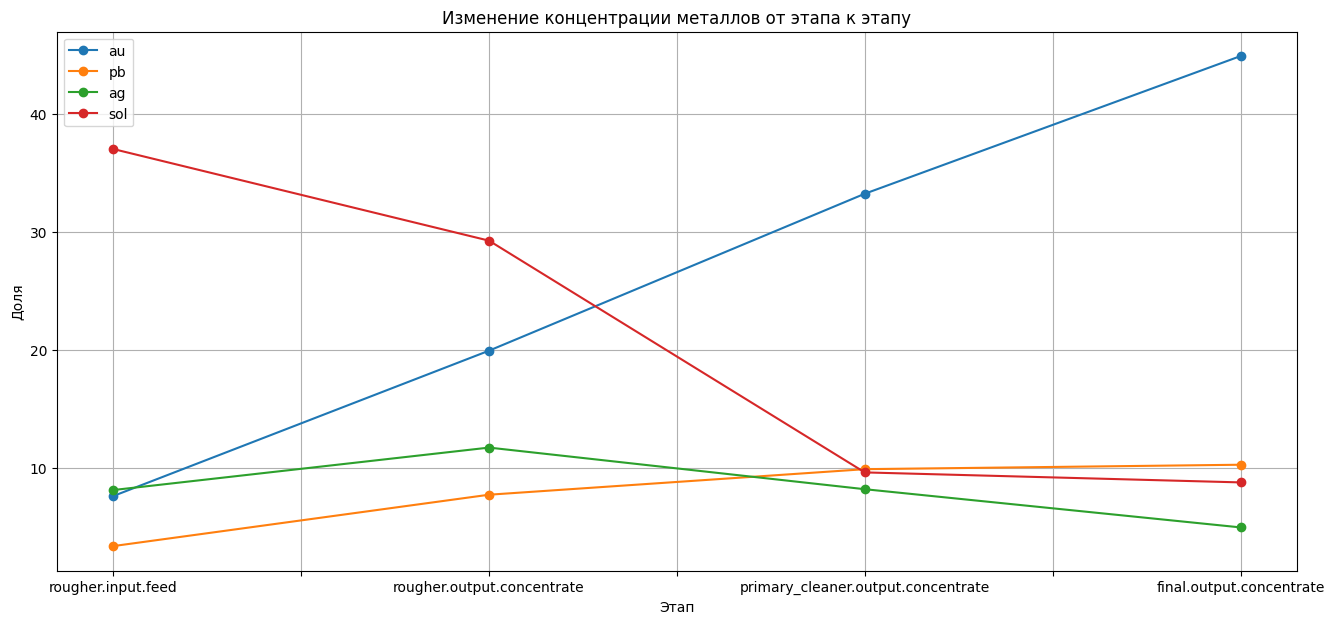

In [24]:
conc_medians = pd.DataFrame(index=metals, columns=stages)

for metal in metals:
    for stage in stages:
        conc_medians[stage][metal] = df['train'][f'{stage}_{metal}'].median()

conc_medians.T.plot(
    style='o-', grid=True, figsize=(16, 7), title='Изменение концентрации металлов от этапа к этапу',
    xlabel='Этап',
    ylabel='Доля')

plt.show()

Из графика видно, что на каждом этапе доля золота в выходящей смеси растёт. После первого шага возрастает доля всех трёх металлов. После этого доля серебра начинает снижаться, а доля свинца также продолжает подрастать (видимо, сопутствующий результат каких-то химических процессов).<br>
Рассмотрим металлы отдельно:

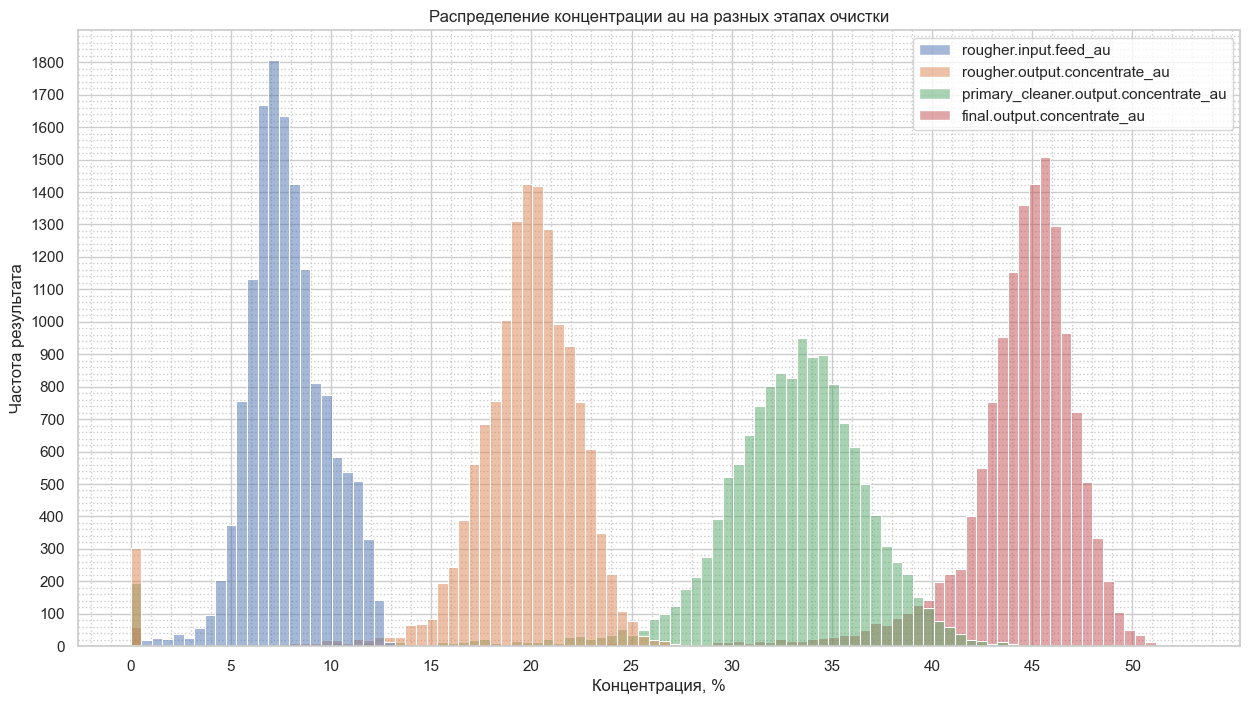

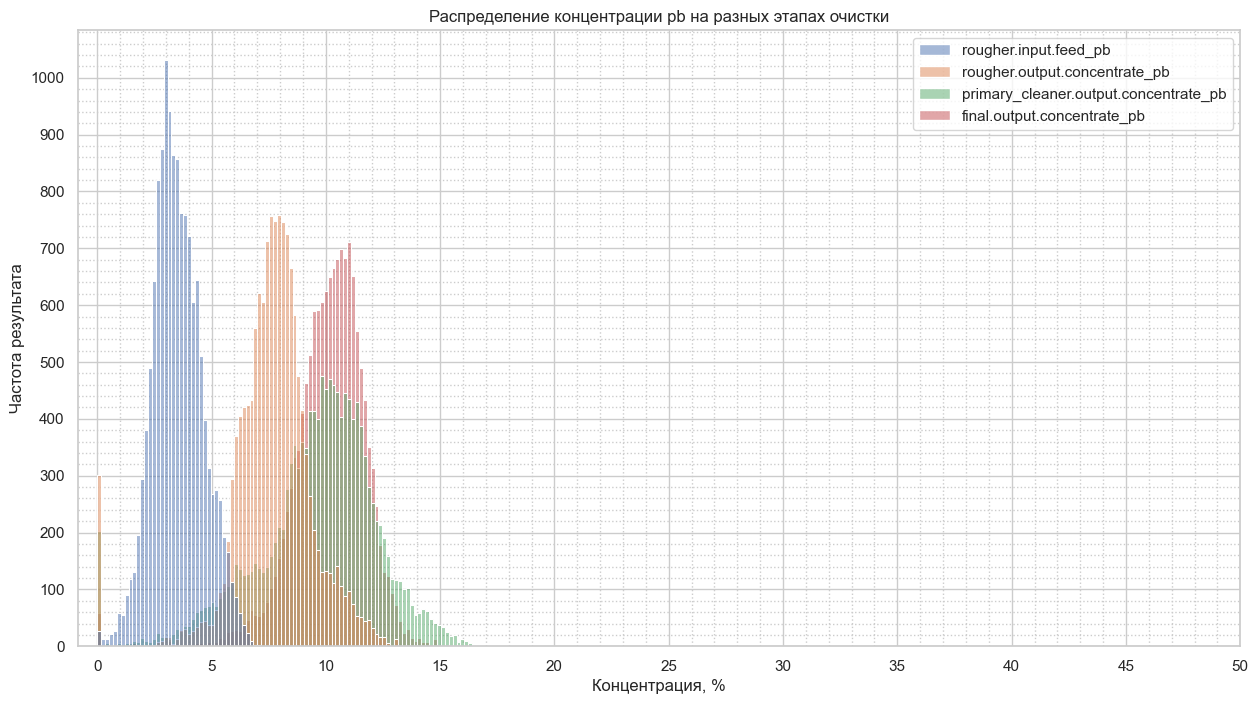

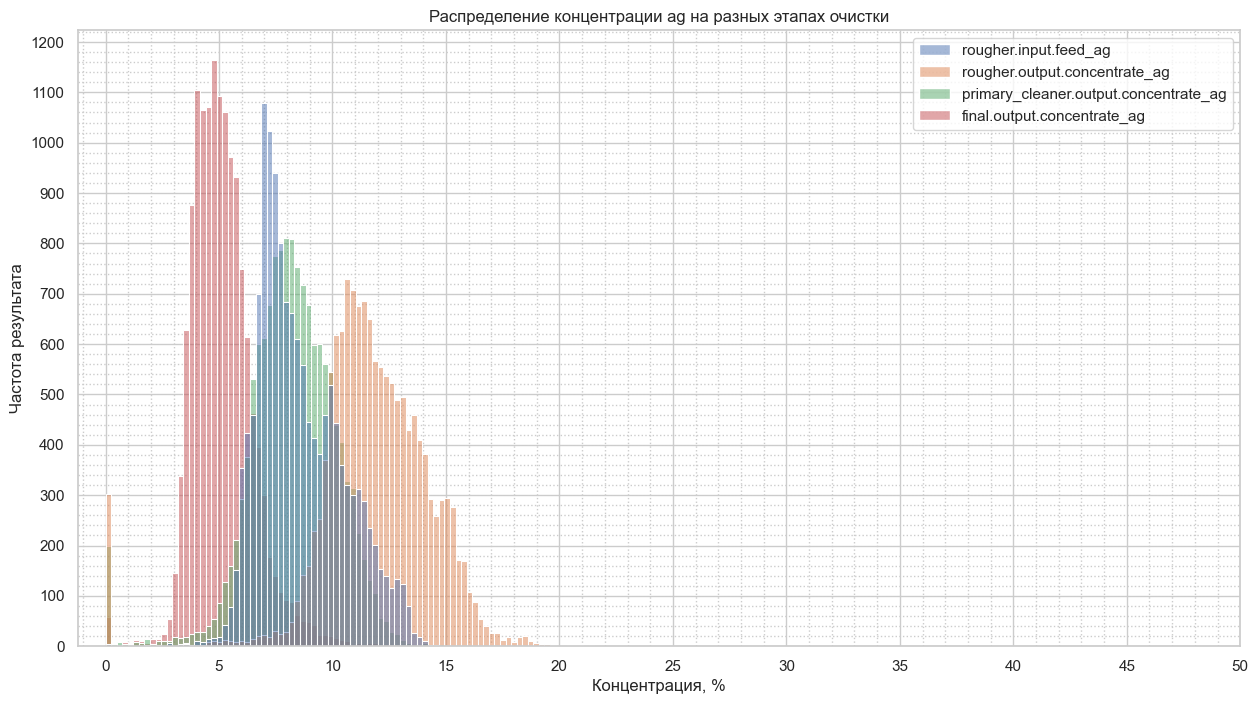

In [25]:
for metal in metals[:-1]:

    sns.set(rc={"figure.figsize":(15, 8)})
    sns.set_style("whitegrid")
    metal_plot = sns.histplot(df['train'][[f'rougher.input.feed_{metal}',
                              f'rougher.output.concentrate_{metal}',
                              f'primary_cleaner.output.concentrate_{metal}',
                              f'final.output.concentrate_{metal}']],
                 bins=100,
                 alpha=0.5).yaxis.set_major_locator(MultipleLocator(100))
    plt.title(f'Распределение концентрации {metal} на разных этапах очистки')
    plt.xlabel('Концентрация, %')
    plt.ylabel('Частота результата')
    plt.xticks(np.arange(0, 55, step=5)) # Масштаб выбран навскидку по зачениям из предыдущего графика
    plt.minorticks_on()

    plt.grid(which='both', color='#CCCCCC', linestyle=':')
    plt.grid(which='major', color='#CCCCCC', linestyle='-')

    plt.show()

На каждом этапе график распределения для золота схож с графиком для свинца - рост концентрации, уменьшение частоты получения результата, в конце резкий рост и при этом стабильность в получении медианного результата сохраняется. У серебра после первичной очистки виден спад, но за счёт снижения концентрации на выходе её значение более предсказуемо - значит, финальная смесь сильнее различается, как правило, в балансе свинца и золота.

### 2.2. Распределение размеров гранул сырья в тренировочной и тестовой выборках.

Здесь важны `primary_cleaner.input.feed_size` и `rougher.input.feed_size`. Если у них распределение примерно одинаковое - меня это устраивает.

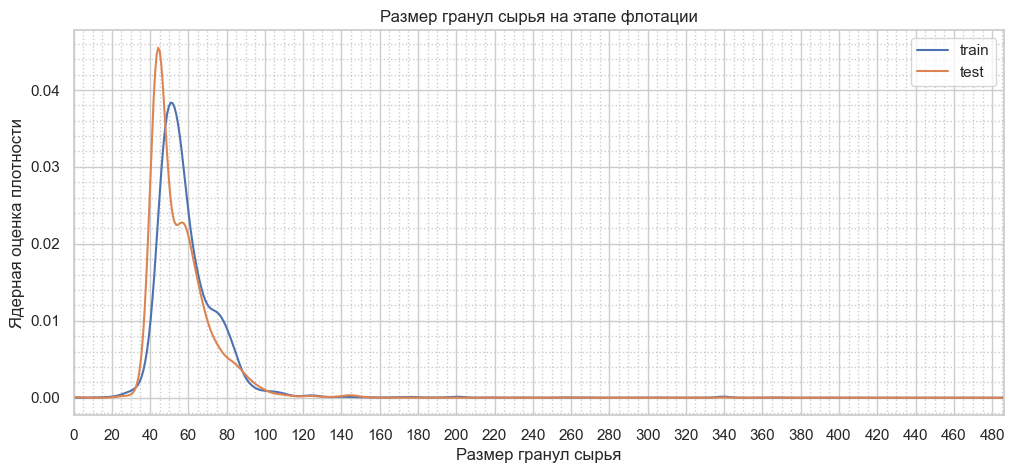

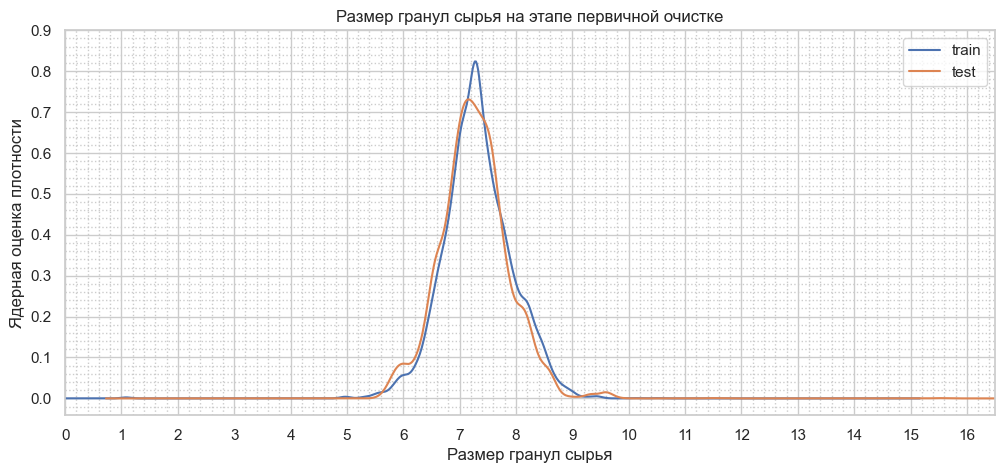

In [26]:
# Настройки графиков
stage_dict = {'rougher.input.feed_size':'флотации', 'primary_cleaner.input.feed_size':'первичной очистке'}
stage_dict_ticks = ({'rougher.input.feed_size':20, 'primary_cleaner.input.feed_size':1},
                {'rougher.input.feed_size':np.arange(0, 0.05, step=0.01),
                'primary_cleaner.input.feed_size':np.arange(0, 1, step=0.1)})

# Вывод графиков
for i in ('rougher.input.feed_size', 'primary_cleaner.input.feed_size'):
    train_plot = df['train'][i].plot.kde(figsize=(12,5), label='train')
    test_plot = df['test'][i].plot.kde(label='test')

    plt.title(f'Размер гранул сырья на этапе {stage_dict[i]}')
    plt.xlabel('Размер гранул сырья')
    plt.ylabel('Ядерная оценка плотности')
    
    plt.xticks(np.arange(0,
                         max(df['train'][i].max(),
                             df['test'][i].max())+1,
                         step=stage_dict_ticks[0][i]))
    plt.yticks(stage_dict_ticks[1][i])
    
    plt.minorticks_on()
    plt.xlim(0, max(df['train'][i].max(),
                    df['test'][i].max())+1)

    plt.grid(which='both', color='#CCCCCC', linestyle=':')
    plt.grid(which='major', color='#CCCCCC', linestyle='-')

    plt.legend()
    plt.show()

За исключением выбросов, графики распределений очень похожи. Флотация имеет на входе разброс размеров от порядка десятков до сотен единиц измерения и это может показаться очень критичным, но я вижу, что на входе в первичную очистку такой огромной разницы нет (она составляет максимум двух-трёхкратные превышения), что говорит о достаточном качестве очистки на флотации, а значит техпроцесс отлажен, это нормальная ситуация и с такими выбросами ничего делать не нужно.

### 2.3. Суммарная концентрация на разных этапах очистки.
Исследую суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

#### 2.3.1. Анализ

In [27]:
for stage in stages:
    df['train'][f'{stage}_sum'] = df['train'][f'{stage}_au'] + df['train'][f'{stage}_pb'] + df['train'][f'{stage}_ag'] + df['train'][f'{stage}_sol']

In [28]:
df['train'][['rougher.input.feed_sum',
             'rougher.output.concentrate_sum',
             'primary_cleaner.output.concentrate_sum',
             'final.output.concentrate_sum']].describe()

,rougher.input.feed_sum,rougher.output.concentrate_sum,primary_cleaner.output.concentrate_sum,final.output.concentrate_sum
count,14149.000000,14149.000000,14149.000000,14149.000000
mean,56.242170,67.173145,60.172546,68.387872
std,7.029808,12.713129,10.448165,7.023723
min,0.040000,0.000000,0.000000,0.000000
25%,52.573579,64.914390,58.046816,67.559819
50%,56.627635,69.175663,61.786946,69.141502
75%,60.763234,73.429261,65.355951,70.974661
max,74.458253,88.140119,76.918076,80.210644


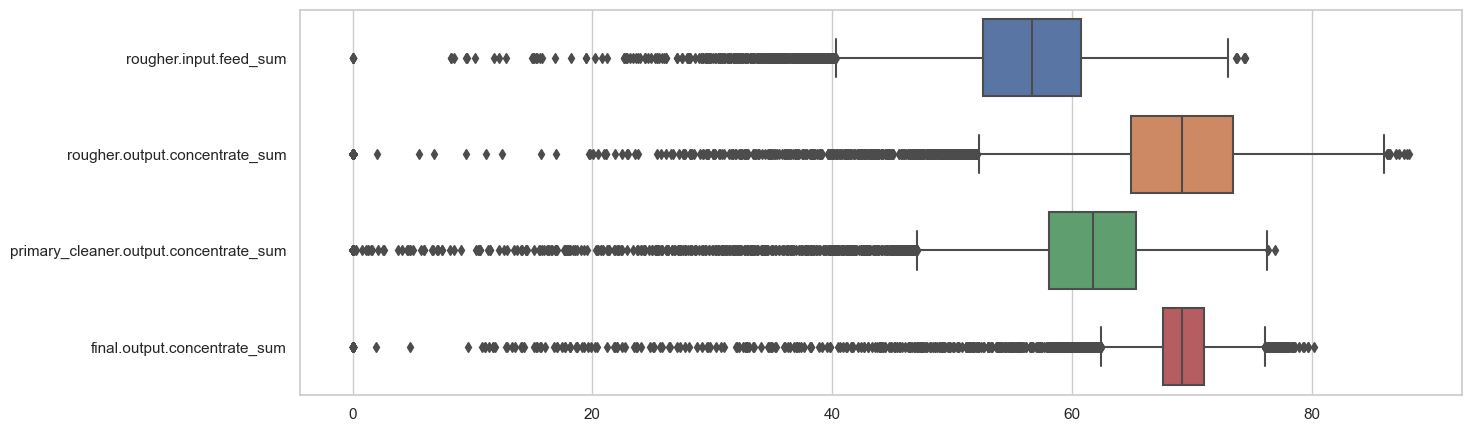

In [29]:
sns.set(rc={"figure.figsize":(15, 5)})
sns.set_style("whitegrid")
sns.boxplot(data=df['train'][['rougher.input.feed_sum',
                             'rougher.output.concentrate_sum',
                             'primary_cleaner.output.concentrate_sum',
                             'final.output.concentrate_sum']],
            orient='h')
plt.show()

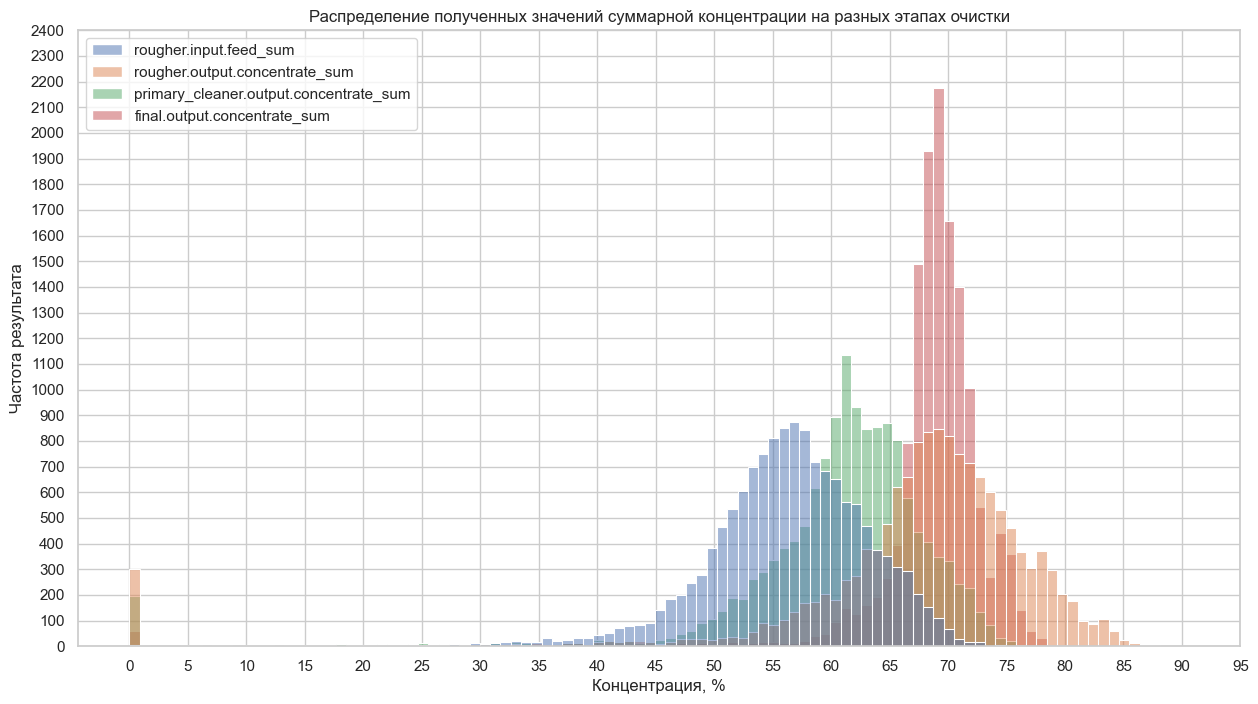

In [30]:
sns.set(rc={"figure.figsize":(15, 8)})
sns.set_style("whitegrid")
sns.histplot(df['train'][['rougher.input.feed_sum',
                          'rougher.output.concentrate_sum',
                          'primary_cleaner.output.concentrate_sum',
                          'final.output.concentrate_sum']],
             bins=100,
             alpha=0.5)

plt.title('Распределение полученных значений суммарной концентрации на разных этапах очистки')
plt.xlabel('Концентрация, %')
plt.ylabel('Частота результата')
plt.xticks(np.arange(0, 100, step=5))
plt.yticks(np.arange(0, 2500, step=100))
# plt.minorticks_on()
plt.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.show()

Видно, что с каждым этапом суммарная концентрация веществ в смеси растёт. Если рассматривать эти же графики без влияния примеси `sol`, то можно увидеть, что их концентрация только растёт, а распределение сужается, показывая, что концентрация самих металлов в смеси явно повышается.<br>
В целом, полученные распределения похожи на правду, но есть выбросы, равные 0 и около него - от них нужно избавиться.

#### 2.3.2. Удаление выбросов
Оценю выбросы около нуля.

In [31]:
df['train'][df['train']['rougher.input.feed_sum'] < 2].count().sum()

450

В районе 2% квантиля сидит 450 строк суммарно. Есть вероятность, что это какие-то отладочные записи, либо сбой оборудования (в т.ч. измерительного) - они не отражают процесс должным образом, не годны к обучению, их можно и нужно удалить.

In [32]:
# Удаляем выбросы
for stage in stages:
    df['train'] = df['train'][df['train'][f'{stage}_sum'] > 2]

In [33]:
# Проверим работу:
display(df['train'].shape)
df['train'][['rougher.input.feed_sum',
             'rougher.output.concentrate_sum',
             'primary_cleaner.output.concentrate_sum',
             'final.output.concentrate_sum']].describe()

(13594, 90)

,rougher.input.feed_sum,rougher.output.concentrate_sum,primary_cleaner.output.concentrate_sum,final.output.concentrate_sum
count,13594.000000,13594.000000,13594.000000,13594.000000
mean,56.254457,68.696527,60.979279,68.717745
std,6.866860,7.921404,7.575501,5.219588
min,8.217984,5.577864,2.121318,11.078117
25%,52.555756,65.313431,58.286157,67.561326
50%,56.619064,69.335791,61.843126,69.143403
75%,60.758700,73.529416,65.362200,70.965612
max,74.458253,88.140119,76.918076,80.210644


Теперь посмотрю на распределение на гистограмме:

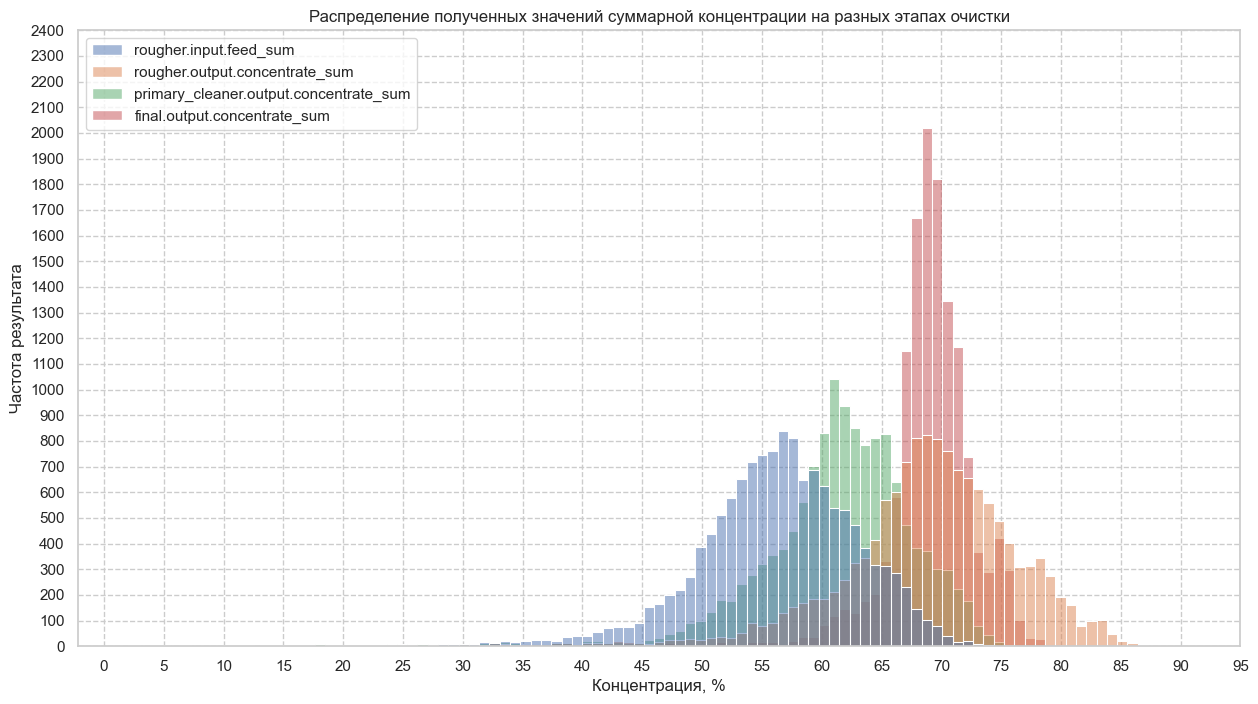

In [34]:
sns.set(rc={"figure.figsize":(15, 8)})
sns.set_style("whitegrid")
sns.histplot(df['train'][['rougher.input.feed_sum',
                          'rougher.output.concentrate_sum',
                          'primary_cleaner.output.concentrate_sum',
                          'final.output.concentrate_sum']],
             bins=100,
             alpha=0.5)
plt.title('Распределение полученных значений суммарной концентрации на разных этапах очистки')
plt.xlabel('Концентрация, %')
plt.ylabel('Частота результата')
plt.xticks(np.arange(0, 100, step=5))
plt.yticks(np.arange(0, 2500, step=100))
plt.minorticks_on()

plt.grid(which='major', color='#CCCCCC', linestyle='--')
plt.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.grid(which='major', color='#CCCCCC', linestyle='--')
plt.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.show()

In [35]:
# После всех манипуляций удаляем новые столбцы и проверяем, что с датасетом всё в порядке
df['train'] = df['train'].drop(['rougher.input.feed_sum',
                  'rougher.output.concentrate_sum',
                  'primary_cleaner.output.concentrate_sum',
                  'final.output.concentrate_sum'], axis=1)
df['train'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13594 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         13594 non-null  float64
 1   final.output.concentrate_pb                         13594 non-null  float64
 2   final.output.concentrate_sol                        13594 non-null  float64
 3   final.output.concentrate_au                         13594 non-null  float64
 4   final.output.recovery                               13594 non-null  float64
 5   final.output.tail_ag                                13594 non-null  float64
 6   final.output.tail_pb                                13594 non-null  float64
 7   final.output.tail_sol                               13594 non-null  float64
 8   final.output.tail_au                     

Аномалии около нуля удалены. Датасет готов к обучению.

## 3. Модель

### 3.1. Метрика sMAPE. Функция её вычисления
Для решения задачи возьму метрику относительной ошибки sMAPE. Она одинаково учтёт масштаб и целевого признака и предсказания.

$$\mathrm{sMAPE} = \frac{1}{N} \sum\limits_{N}^{i=1} \frac{|y_i-\hat y_i|}{(|y_i|+|\hat y_i|)/2}\times 100\%$$

Нужно спрогнозировать сразу две величины для двух ключевых этапов:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

Поэтому итоговую метрику сложу из двух величин:
$$\textrm{Итоговое sMAPE} = 25\%\times \mathrm{sMAPE}(rougher) + 75\%\times \mathrm{sMAPE}(final)$$

In [36]:
# Две раздельные функции для make_scorer.
# smape выделена отдельно для make_scorer

def smape(y:float, p:float) -> float:
    '''
    Функция вычисления sMAPE для одной выборки. На вход принимает предсказания и истинные значения, на выход отдаёт расчётное число.
    y - истинные значения
    p - предсказания
    '''
    n = len(y)
    return np.mean((abs(y-p)/((abs(y)+abs(p))*.5))) * 100


def total_smape(score_rougher:float, score_final:float) -> float:
    '''
    Функция вычисления итогового sMAPE модели.
    На вход принимает два расчётных sMAPE для промежуточных моделей
    На выход отдаёт одно число итогового sMAPE
    '''
    return .25*abs(score_rougher) + .75*abs(score_final)

### 3.2. Обучение моделей.
Нужно спрогнозировать сразу две величины:
1. Эффективность обогащения чернового концентрата `rougher.output.recovery`;
1. Эффективность обогащения финального концентрата `final.output.recovery`.

#### 3.2.1. Подготовка выборок.

Для обучения беру датасет `train` и делю его на две части: для раздельного обучения моделей для флотации и финальной очистки.<br>
Для флотации беру признаки по маске `rougher.`, для очистки - остальные.<br>
Для тестирования потребуется датасет `test` и по его индексам выделятся целевые признаки из датасета `full`.

In [37]:
# Список колонок, которые должны остаться в обучающих выборках - берём из выборки test.
cols_to_save = df['test'].columns

In [38]:
# Выделяем целевые признаки.
y_train_rougher = df['train']['rougher.output.recovery']
y_train_final = df['train']['final.output.recovery']

# Убираем из общего обучающего датафрейма столбцы, которые нам не нужны.
X_train_final = df['train'][cols_to_save]
# Делим тренировочный датафрейм на два для разных этапов и проверяем разделение.
X_train_rougher = X_train_final.loc[:,X_train_final.columns.str.startswith('rougher')]

In [39]:
# Для удобства
y_train_rougher = pd.Series(y_train_rougher, index=y_train_rougher.index)
y_train_final = pd.Series(y_train_final, index=y_train_final.index)

In [40]:
# Проверяем размеры.
display(X_train_rougher.shape)
display(y_train_rougher.shape)
display(X_train_final.shape)
display(y_train_final.shape)

# Проверяем совпадение индексов.
display(sum(X_train_rougher.index == y_train_rougher.index))
display(sum(X_train_final.index == y_train_final.index))
display(sum(X_train_rougher.index == X_train_final.index))

(13594, 22)

(13594,)

(13594, 52)

(13594,)

13594

13594

13594

В тестовой выборке также были пропуски. В дальнейших расчётах они помешают работе функций, поэтому обработаю таким же методом, как и в обучающей выборке.

In [41]:
df['test'].ffill(inplace=True)

In [42]:
display(df['test'].isna().sum())

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

In [43]:
# Выделяем целевые признаки.
y_test_rougher = df['full'].loc[df['test'].index]['rougher.output.recovery']
y_test_final = df['full'].loc[df['test'].index]['final.output.recovery']

y_test_rougher = pd.Series(y_test_rougher, index=y_test_rougher.index)
y_test_final = pd.Series(y_test_final, index=y_test_final.index)

# Делим тестовый датафрейм на два.
# Оставляем в выборках только те столбцы, которые нам нужны.
X_test_rougher = df['test'].loc[:,df['test'].columns.str.startswith('rougher')]
X_test_final = df['test'].copy()

In [44]:
display(X_test_rougher.shape)
display(y_test_rougher.shape)
display(X_test_final.shape)
display(y_test_final.shape)

# Проверяем совпадение индексов
display(sum(X_test_rougher.index == y_test_rougher.index))
display(sum(X_test_final.index == y_test_final.index))
display(sum(X_test_rougher.index == X_test_final.index))

(5290, 22)

(5290,)

(5290, 52)

(5290,)

5290

5290

5290

#### 3.2.2. Настройки

In [45]:
# Задаём параметры кросс-валидации KF
kf = KFold(n_splits=4, shuffle=True, random_state=55555)

In [46]:
# На основе нашей функции обучим метрику
smape_scorer = make_scorer(smape, greater_is_better=False)

#### 3.2.3. Оценка обучения навскидку cross_val_score

In [47]:
# Дерево решений
cv_train_rougher_dt = abs(cross_val_score(DecisionTreeRegressor(random_state=55555), X_train_rougher, y_train_rougher, cv=kf, scoring=smape_scorer)).mean()
cv_train_final_dt = abs(cross_val_score(DecisionTreeRegressor(random_state=55555), X_train_final, y_train_final, cv=kf, scoring=smape_scorer)).mean()
display(cv_train_rougher_dt)
display(cv_train_final_dt)
display(total_smape(cv_train_rougher_dt, cv_train_final_dt))

3.9579777257737825

8.192513127046391

7.13387927672824

In [48]:
# Случайный лес
cv_train_rougher_rf = abs(cross_val_score(RandomForestRegressor(random_state=55555), X_train_rougher, y_train_rougher, cv=kf, scoring=smape_scorer)).mean()
cv_train_final_rf = abs(cross_val_score(RandomForestRegressor(random_state=55555), X_train_final, y_train_final, cv=kf, scoring=smape_scorer)).mean()

display(cv_train_rougher_rf)
display(cv_train_final_rf)
display(total_smape(cv_train_rougher_rf, cv_train_final_rf))

2.8070563306889302

5.685287003320689

4.96572933516275

In [49]:
# Линейная регрессия
cv_train_rougher_lr = abs(cross_val_score(LinearRegression(), X_train_rougher, y_train_rougher, cv=kf, scoring=smape_scorer)).mean()
cv_train_final_lr = abs(cross_val_score(LinearRegression(), X_train_final, y_train_final, cv=kf, scoring=smape_scorer)).mean()

display(cv_train_rougher_lr)
display(cv_train_final_lr)
display(total_smape(cv_train_rougher_lr, cv_train_final_lr))

5.0923576658008844

7.966034253686326

7.2476151067149654

In [50]:
# Эластичная сеть
cv_train_rougher_en = abs(cross_val_score(ElasticNet(random_state=55555), X_train_rougher, y_train_rougher, cv=kf, scoring=smape_scorer)).mean()
cv_train_final_en = abs(cross_val_score(ElasticNet(random_state=55555), X_train_final, y_train_final, cv=kf, scoring=smape_scorer)).mean()

display(cv_train_rougher_en)
display(cv_train_final_en)
display(total_smape(cv_train_rougher_en, cv_train_final_en))

5.165214106076197

8.10454444602842

7.369711861040365

Предварительно видно, что линейные модели показывают себя хуже (явно влияние мульиколлинеарности). Для чистоты эксперимента оставлю, но очевидно что линейная регрессия даст худший результат: у неё особенно и нечего настривать, тогда как эластик богат на гиперпараметры и его можно как-то вытянуть.

#### 3.2.3.а Обучение моделей. Дерево решений

In [51]:
param_grid_dt = {'max_depth': range(1, 21, 1),
                 'min_samples_leaf': range(1, 10, 1)}

In [52]:
# Флотация
rougher_dt = RandomizedSearchCV(DecisionTreeRegressor(random_state=55555),
                                param_distributions = param_grid_dt,
                                cv=kf,
                                n_iter=30,
                                scoring=smape_scorer)

In [53]:
%%time

rougher_dt.fit(X_train_rougher, y_train_rougher)

CPU times: total: 20.2 s
Wall time: 20.2 s


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=55555, shuffle=True),
                   estimator=DecisionTreeRegressor(random_state=55555),
                   n_iter=30,
                   param_distributions={'max_depth': range(1, 21),
                                        'min_samples_leaf': range(1, 10)},
                   scoring=make_scorer(smape, greater_is_better=False))

In [54]:
print(f'Лучший sMAPE дерева решений для флотации: {abs(rougher_dt.best_score_)}')
display(rougher_dt.best_params_)

Лучший sMAPE дерева решений для флотации: 3.593709687751839


{'min_samples_leaf': 9, 'max_depth': 12}

In [55]:
# Финальный концентрат
final_dt = RandomizedSearchCV(DecisionTreeRegressor(random_state=55555),
                              param_distributions = param_grid_dt,
                              cv=kf,
                              n_iter=30,
                              scoring=smape_scorer)

In [56]:
%%time

final_dt.fit(X_train_final, y_train_final)

CPU times: total: 44.2 s
Wall time: 44.2 s


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=55555, shuffle=True),
                   estimator=DecisionTreeRegressor(random_state=55555),
                   n_iter=30,
                   param_distributions={'max_depth': range(1, 21),
                                        'min_samples_leaf': range(1, 10)},
                   scoring=make_scorer(smape, greater_is_better=False))

In [57]:
print(f'Лучший sMAPE дерева решений для финального концентрата: {abs(final_dt.best_score_)}')
display(final_dt.best_params_)

Лучший sMAPE дерева решений для финального концентрата: 7.2319063499542615


{'min_samples_leaf': 6, 'max_depth': 11}

In [58]:
dt_best_score = total_smape(rougher_dt.best_score_, final_dt.best_score_)
print(f'Итоговый sMAPE дерева решений: {dt_best_score}')

Итоговый sMAPE дерева решений: 6.322357184403656


#### 3.2.3.б Обучение моделей. Случайный лес

In [59]:
param_grid_rf = {#'max_depth': range(1, 21, 1),
              'n_estimators': range(11, 31, 5),
              'min_samples_leaf':range(2, 4),
              'ccp_alpha':np.arange(0.01, 0.06, 0.02)}

In [60]:
# Флотация
rougher_rf = RandomizedSearchCV(RandomForestRegressor(random_state=55555),
                                param_distributions=param_grid_rf,
                                cv=kf,
                                verbose=3,
                                scoring=smape_scorer)

In [61]:
%%time

rougher_rf.fit(X_train_rougher, y_train_rougher)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END ccp_alpha=0.03, min_samples_leaf=2, n_estimators=26; total time=   3.9s
[CV 2/4] END ccp_alpha=0.03, min_samples_leaf=2, n_estimators=26; total time=   4.0s
[CV 3/4] END ccp_alpha=0.03, min_samples_leaf=2, n_estimators=26; total time=   3.9s
[CV 4/4] END ccp_alpha=0.03, min_samples_leaf=2, n_estimators=26; total time=   3.9s
[CV 1/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=3, n_estimators=11; total time=   1.4s
[CV 2/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=3, n_estimators=11; total time=   1.4s
[CV 3/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=3, n_estimators=11; total time=   1.4s
[CV 4/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=3, n_estimators=11; total time=   1.4s
[CV 1/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=2, n_estimators=26; total time=   3.9s
[CV 2/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=2, n_estimators=26; total time= 

RandomizedSearchCV(cv=KFold(n_splits=4, random_state=55555, shuffle=True),
                   estimator=RandomForestRegressor(random_state=55555),
                   param_distributions={'ccp_alpha': array([0.01, 0.03, 0.05]),
                                        'min_samples_leaf': range(2, 4),
                                        'n_estimators': range(11, 31, 5)},
                   scoring=make_scorer(smape, greater_is_better=False),
                   verbose=3)

In [62]:
print(f'Лучший sMAPE случайного леса для флотации: {abs(rougher_rf.best_score_)}')
display(rougher_rf.best_params_)

Лучший sMAPE случайного леса для флотации: 3.0633948401021636


{'n_estimators': 16, 'min_samples_leaf': 2, 'ccp_alpha': 0.01}

In [63]:
# Финальный концентрат
final_rf = RandomizedSearchCV(RandomForestRegressor(random_state=55555),
                              param_distributions=param_grid_rf,
                              cv=kf,
                              verbose=3,
                              scoring=smape_scorer)

In [64]:
%%time

final_rf.fit(X_train_final, y_train_final)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=2, n_estimators=21; total time=   8.3s
[CV 2/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=2, n_estimators=21; total time=   8.7s
[CV 3/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=2, n_estimators=21; total time=   8.4s
[CV 4/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=2, n_estimators=21; total time=   8.5s
[CV 1/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=3, n_estimators=21; total time=   7.7s
[CV 2/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=3, n_estimators=21; total time=   7.8s
[CV 3/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=3, n_estimators=21; total time=   7.6s
[CV 4/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=3, n_estimators=21; total time=   7.6s
[CV 1/4] END ccp_alpha=0.049999999999999996, min_samples_leaf=3, n_estimators=11; total time=   3.9s
[CV 2/4] END ccp_alpha=0.04999

RandomizedSearchCV(cv=KFold(n_splits=4, random_state=55555, shuffle=True),
                   estimator=RandomForestRegressor(random_state=55555),
                   param_distributions={'ccp_alpha': array([0.01, 0.03, 0.05]),
                                        'min_samples_leaf': range(2, 4),
                                        'n_estimators': range(11, 31, 5)},
                   scoring=make_scorer(smape, greater_is_better=False),
                   verbose=3)

In [65]:
print(f'Лучший sMAPE случайного леса для финальной выборки: {abs(final_rf.best_score_)}')
display(final_rf.best_params_)

Лучший sMAPE случайного леса для финальной выборки: 5.944110247908338


{'n_estimators': 16, 'min_samples_leaf': 2, 'ccp_alpha': 0.01}

In [66]:
rf_best_score = total_smape(rougher_rf.best_score_, final_rf.best_score_)
print(f'Итоговый sMAPE случайного леса: {rf_best_score}')

Итоговый sMAPE случайного леса: 5.223931395956794


#### 3.2.3.в Обучение моделей. Линейная регрессия

In [67]:
# Флотация
rougher_lr = RandomizedSearchCV(LinearRegression(),
                                param_distributions = {'normalize':[True,False]},
                                cv=kf,
                                scoring=smape_scorer)

In [68]:
%%time

rougher_lr.fit(X_train_rougher, y_train_rougher)

CPU times: total: 109 ms
Wall time: 125 ms


C:\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=55555, shuffle=True),
                   estimator=LinearRegression(),
                   param_distributions={'normalize': [True, False]},
                   scoring=make_scorer(smape, greater_is_better=False))

In [69]:
# Финальный концентрат
final_lr = RandomizedSearchCV(LinearRegression(),
                              param_distributions = {'normalize':[True,False]},
                              cv=kf,
                              scoring=smape_scorer)

In [70]:
%%time

final_lr.fit(X_train_final, y_train_final)

C:\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 500 ms
Wall time: 306 ms


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=55555, shuffle=True),
                   estimator=LinearRegression(),
                   param_distributions={'normalize': [True, False]},
                   scoring=make_scorer(smape, greater_is_better=False))

In [71]:
print(f'Лучший sMAPE линейной регрессии для финального концентрата: {abs(final_lr.best_score_)}')
display(final_lr.best_params_)

Лучший sMAPE линейной регрессии для финального концентрата: 7.966034253686326


{'normalize': False}

In [72]:
lr_best_score = total_smape(rougher_lr.best_score_, final_lr.best_score_)
print(f'Итоговый sMAPE линейной регрессии: {lr_best_score}')

Итоговый sMAPE линейной регрессии: 7.2476151067149654


Ковыряние в линейке не приводит ни к чему хорошему. У неё особенно и нечего перебирать, нужно подобрать другую модель на её основе, например, ElasticNet.

#### 3.2.3.г Обучение моделей. Эластичная сеть

In [73]:
param_grid_en = {'alpha':range(1, 41, 2),
              'l1_ratio':np.arange(0.1, 1.1, 0.1),
              'warm_start':[True,False]}

In [74]:
# Флотация
rougher_en = RandomizedSearchCV(ElasticNet(random_state=55555),
                                param_distributions = param_grid_en,
                                cv=kf,
                                scoring=smape_scorer)

In [75]:
%%time

rougher_en.fit(X_train_rougher, y_train_rougher)

CPU times: total: 26.7 s
Wall time: 21.2 s


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=55555, shuffle=True),
                   estimator=ElasticNet(random_state=55555),
                   param_distributions={'alpha': range(1, 41, 2),
                                        'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'warm_start': [True, False]},
                   scoring=make_scorer(smape, greater_is_better=False))

In [76]:
print(f'Лучший sMAPE эластичной сети для флотации: {abs(rougher_en.best_score_)}')
display(rougher_en.best_params_)

Лучший sMAPE эластичной сети для флотации: 5.165214106076197


{'warm_start': True, 'l1_ratio': 0.5, 'alpha': 1}

In [77]:
# Финальный концентрат
final_en = RandomizedSearchCV(ElasticNet(random_state=55555),
                              param_distributions = param_grid_en,
                              cv=kf,
                              scoring=smape_scorer)

In [78]:
%%time

final_en.fit(X_train_final, y_train_final)

CPU times: total: 46.7 s
Wall time: 37.3 s


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=55555, shuffle=True),
                   estimator=ElasticNet(random_state=55555),
                   param_distributions={'alpha': range(1, 41, 2),
                                        'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'warm_start': [True, False]},
                   scoring=make_scorer(smape, greater_is_better=False))

In [79]:
print(f'Лучший sMAPE эластичной сети для финального концентрата: {abs(final_en.best_score_)}')
display(final_en.best_params_)

Лучший sMAPE эластичной сети для финального концентрата: 8.178963813255706


{'warm_start': False, 'l1_ratio': 0.8, 'alpha': 1}

In [80]:
en_best_score = total_smape(rougher_en.best_score_, final_en.best_score_)
print(f'Итоговый sMAPE эластичной сети: {en_best_score}')

Итоговый sMAPE эластичной сети: 7.425526386460829


#### 3.2.4. Промежуточный вывод.

In [81]:
stage_scores = {'Флотация':[abs(rougher_dt.best_score_), abs(rougher_rf.best_score_), abs(rougher_lr.best_score_), abs(rougher_en.best_score_)],
                'Финальный концентрат':[abs(final_dt.best_score_), abs(final_rf.best_score_), abs(final_lr.best_score_), abs(final_en.best_score_)],
                'Итоговый sMAPE':[dt_best_score, rf_best_score, lr_best_score, en_best_score]}

df_tested = pd.DataFrame(stage_scores, index =['decision_tree', 'random_forest', 'linear_regression', 'elasticnet'])

display(df_tested)

,Флотация,Финальный концентрат,Итоговый sMAPE
decision_tree,3.593710,7.231906,6.322357
random_forest,3.063395,5.944110,5.223931
linear_regression,5.092358,7.966034,7.247615
elasticnet,5.165214,8.178964,7.425526


Лучший результат метрики sMAPE даёт случайный лес.

#### 3.2.5.1. Тестовый набор данных.

In [82]:
# Получаем предсказания.
test_pred_rougher = rougher_rf.predict(X_test_rougher)
test_pred_final = final_rf.predict(X_test_final)

In [83]:
best_rougher_score = smape(y_test_rougher, test_pred_rougher)
best_final_score = smape(y_test_final, test_pred_final)
best_score = total_smape(best_rougher_score, best_final_score)

print(f'sMAPE флотации: {best_rougher_score}')
print(f'sMAPE финального концентрата: {best_final_score}')
print(f'Итоговый sMAPE : {best_score}')

sMAPE флотации: 8.303716832467742
sMAPE финального концентрата: 9.775976192389004
Итоговый sMAPE : 9.40791135240869


#### 3.2.5.2.а Константная модель.

Сравню с константной моделью. За константную модель приму свою функцию, переписанную от медианы целевого признака.

In [84]:
def smape_const(y:float) -> float:
    '''
    Функция вычисления sMAPE константной модели одной выборки на основе медианы целевого признака.
    y - истинные значения
    '''
    m = y.median()
    return np.mean((abs(y-m)/((abs(y)+abs(m))*.5))) * 100

In [85]:
const_train_rougher_score = smape_const(y_train_rougher)
const_train_final_score = smape_const(y_train_final)
const_train_score = total_smape(const_train_rougher_score, const_train_final_score)

print(f'sMAPE флотации на константной модели: {const_train_rougher_score}')
print(f'sMAPE финального концентрата на константной модели: {const_train_final_score}')
print(f'Итоговый sMAPE на константной модели: {const_train_score}')

sMAPE флотации на константной модели: 7.229961247656913
sMAPE финального концентрата на константной модели: 10.039177820282521
Итоговый sMAPE на константной модели: 9.33687367712612


#### 3.2.5.2.б DummyRegressor

In [86]:
# Обучаем дамми-модели
dummy_train_rougher = DummyRegressor(strategy='constant',
                                     constant=y_train_rougher.median()).fit(X_train_rougher, y_train_rougher)
dummy_train_final = DummyRegressor(strategy='constant',
                                   constant=y_train_final.median()).fit(X_train_final, y_train_final)

# Делаем на них предсказания.
dummy_train_rougher_preds = dummy_train_rougher.predict(X_train_rougher)
dummy_train_final_preds = dummy_train_final.predict(X_train_final)

# Считаем sMAPE.
dummy_train_rougher_score = smape(y_train_rougher, dummy_train_rougher_preds)
dummy_train_final_score = smape(y_train_final, dummy_train_final_preds)
dummy_train_score = total_smape(dummy_train_rougher_score, dummy_train_final_score)


print(f'sMAPE флотации на константной модели: {dummy_train_rougher_score}')
print(f'sMAPE финального концентрата на константной модели: {dummy_train_final_score}')
print(f'Итоговый sMAPE на константной модели: {dummy_train_score}')

sMAPE флотации на константной модели: 7.229961247656913
sMAPE финального концентрата на константной модели: 10.039177820282521
Итоговый sMAPE на константной модели: 9.33687367712612


В целом, результат получился лучше константной модели.

### 3.3 Вывод
Объединю полученные данные по лучшей модели:

In [87]:
total_scores = {'Флотация':[abs(rougher_rf.best_score_), best_rougher_score, const_train_rougher_score],
        'Финальный концентрат':[abs(final_rf.best_score_), best_final_score, const_train_final_score],
        'Итоговый sMAPE':[rf_best_score, best_score, const_train_score]}
  

df_total = pd.DataFrame(total_scores, index =['Случайный лес на тренировочной выборке',
                                              'Случайный лес на тестовой выборке',
                                              'Константная модель на тренировочной выборке'])

display(df_total)

,Флотация,Финальный концентрат,Итоговый sMAPE
Случайный лес на тренировочной выборке,3.063395,5.944110,5.223931
Случайный лес на тестовой выборке,8.303717,9.775976,9.407911
Константная модель на тренировочной выборке,7.229961,10.039178,9.336874


In [88]:
display(y_train_final.median()*best_score/100)
display(y_train_final.mean()*best_score/100)

6.345188001272931

6.284530501714088

Как видно из таблицы, модель адекватна, переобучена не сильно. Итоговый sMAPE составляет меньше 10%, что в единицах измерения recovery (проценты) даёт отклонение порядка 6,3%. Т.к. порог точности нам не задан, то насколько приемлем такой результат нам неизвестно.<br>
Модель имеет какую-то долю переобучения, но её тонкая настройка (не попавшая в отчёт) занимала слишком много времени и не давала существенного улучшения результатов - имеет смысл повторить исследование с применением бустинговых моделей.